# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Подключение библиотек и чтение файла

In [1]:
#подключение библиотек
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
import time 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error


In [2]:
#читаем файл с сайта или с компа 
try:
    df = pd.read_csv('/datasets/autos.csv')

except:
    df = pd.read_csv('/home/dmitrii/Документы/ucheba/autos.csv')

In [3]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Анализ пропусков, выбросов, избыточной информации.

Рассмотрим распределение количественных величин у колонок с целью выявления аномалий и выбросов. Гистограмма показывает, что колонки с ценой, датой регистрации и мощностью требуют очистки. Недостатком датасета для обучения является отсутствие пробегов выше 150 тыс.км., что накладывает ограничение на модель предсказания, которое будет отмечено в заключении. 

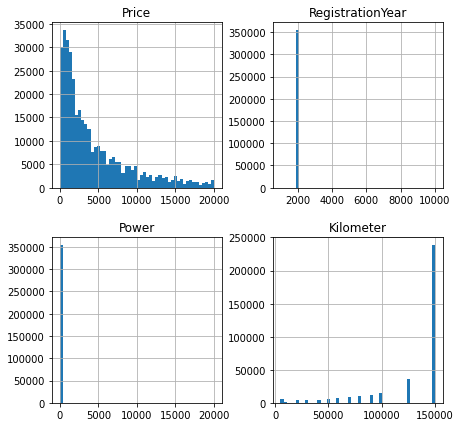

In [5]:
old_size = df.shape[0]
list_hist = ['Price','RegistrationYear','Power','Kilometer','FuelType']
df[list_hist].hist(bins=50,figsize = (7,7));

Ограничим нижнюю ценю автомобиля 200 у.е.

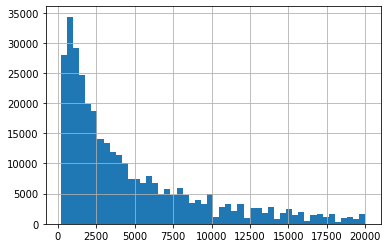

In [6]:
df = df[df['Price']>=200]
df['Price'].hist(bins=50);

Введем ограничение о том, что дата регистрации машины должна быть не старше 1990 года, т.к. цена на более старые машины зависит от фактического состояния, а не от характеристик машины.

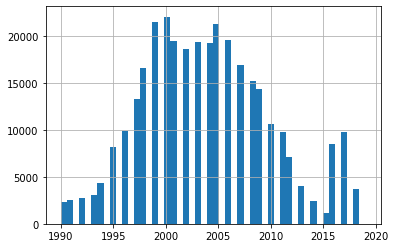

In [7]:
df = df[(df['RegistrationYear']>=1990)&(df['RegistrationYear']<2023)]
df['RegistrationYear'].hist(bins=50);

Мощность машины нулевой быть не может и установить ее представляет сложную задачу, поэтому удалим из датасета машины с мощностью менее 30л.с.,а так же с мощностью выше 99 перцентля.

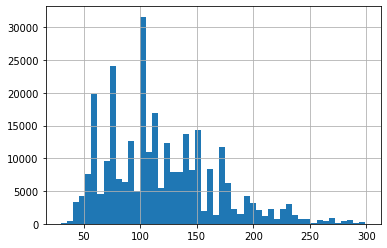

In [8]:
df = df[(df['Power']>=30)&(df['Power']<df['Power'].quantile(0.99))]
df['Power'].hist(bins=50);

Модель машины является объективно важной величиной. Заполнить пропуски в этой колонки без внесения искажения трудная задача, поэтому избавимся от пропусков удалением таких строк. 

In [9]:
df = df.dropna(subset=['Model'])

Факт ремонта отсутствует у большого количества строк. Рассмотрим эту проблему под тем углом, что отсутствие информации это тоже информация. Пометим такие машины "0", подразумевая машины с неизвестной историей. 

In [10]:
df['Repaired'] = df['Repaired'].fillna('0')

Анализируя оставшиеся пропуски видим, что большое количество пропусков имеется в колонке типа машины. По модели машины(например Qashqai) мы можем восстановить без потери данных тип транспортного средства(SUV). Обратное при этом невозможно. Ввиду того, что тип транспортного средства является обобщением разных моделей, то уместно удалить эту колонку.   
Т.к. данные мы готовим для обучения, то не все колонки подходят для обучения. Рассмотрим подробнее.
1. DateCrawled, DateCreated, LastSeen, RegistrationMonth - даты не должны играть роль, т.к. алгоритм должен найти зависимость между ценой и характеристиками машины, а не датой выставления. 
2. NumberOfPictures - добавление или удаление картинок не должно влиять на цену машины с точки зрения работы алгоритма ввиду комичной ситуации, когда добавление/удаление фото меняет цену машины. Для эксперта-человека это уже важная информация, но не для алгоритма. 
3. PostalCode - локационный параметр, который будет оказывать дискриминационное влияние. В случае необходимости учета данного параметра желательно обобщить в более крупные регионы. В данной работе лучше его удалить.

In [11]:
df.drop(['DateCrawled','VehicleType','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1,inplace=True)

Пропуски о типе топлива можно заполнить, используя теорию о том, что тип топлива у одной и той модели машины с одной и такой же мощностью будут одинаковы. Для этого сгруппируем по модели и мощности и сведем это в справочный датафрейм. 

In [12]:
#группируем по модели и мощности двигателя в "справочный" датафрейм
df_info = df.groupby(by=['Model','Power']).mean()

In [13]:
#добавляем колонку с типом топлива(к сожалению сразу сделать это в groupby не получается)
for i in range(len(df_info)):
    df_info.loc[df_info.index[i],'FuelType'] = df.loc[ (df['Model']==df_info.index[i][0])&(df['Power']==df_info.index[i][1]) ,'FuelType'].iloc[0]

In [14]:
#заполняем пропуски из справочного датафрейма, который создали выше
for i in df.index[ df['FuelType'].isnull() ].tolist():
    df.loc[i,'FuelType'] = df_info.loc[(df.loc[i,'Model'],df.loc[i,'Power']),'FuelType']

In [15]:
df.isna().sum()

Price                  0
RegistrationYear       0
Gearbox             4825
Power                  0
Model                  0
Kilometer              0
FuelType            2264
Brand                  0
Repaired               0
dtype: int64

Оставшиеся пропуски в строках уже труднее заполнить без внесения искажения. Удалим эти строки.

In [16]:
df = df.dropna()

Оцениваем потери датафрейма. При этом следует отметить, что в данной работе не производится анализ данных, а происходит обучение модели. Важно не количество строк, а то насколько правильно они отражают зависимости. 

In [17]:
loss = abs(df.shape[0] - old_size)/old_size
print('Потеря датафрейма после очистки',loss*100,'%')

Потеря датафрейма после очистки 22.434524464611748 %


### Разделение выборки 
Ввиду того, что обучение будем производить методом кросс-валидации разделим датасет на две части - тренировочную и тестовую.

In [18]:
#Разделение на целевую и множество признаков
target = df['Price']
features = df.drop('Price', axis=1)
#Разделение на обучающую и тестовую
features_train, features_test, target_train,target_test = train_test_split(
    features, 
    target, 
    test_size=0.8, 
    random_state=12345)

## Обучение моделей

### Catboost

Библиотека catboost позволяет строить модели с категориальными признаками без использования отдельного метода кодирования. Воспользуемся данным приемуществом. 

In [19]:
#инициализируем 
cat_boost = cb.CatBoostRegressor(iterations=70,random_state=12345)
#список категориальных переменных
categorical_indicies = ['Gearbox','Model','FuelType','Brand','Repaired']
#список гиперпараметров для перебора
grid = {'learning_rate': [0.02, 0.04],
        'depth': [3,6]}
grid_cb = GridSearchCV(cat_boost, grid,cv=5, scoring='neg_root_mean_squared_error')

grid_cb.fit(features_train,
         target_train,
         plot=False,
         verbose=False,
         cat_features=categorical_indicies);

Для оценки скорости обучения сохраним данные в датафремейме с временем обучения и предсказания модели с лучшими гиперпараметрами. 

In [20]:
df_result = pd.DataFrame(data={'Eval':['CatBoost'],
                               'Time_fit':[ grid_cb.cv_results_['mean_fit_time'][grid_cb.best_index_] ] ,
                               'Time_pred':[ grid_cb.cv_results_['mean_score_time'][grid_cb.best_index_] ] ,
                               'RMSE':[ abs( grid_cb.cv_results_['mean_test_score'][grid_cb.best_index_]) ] } )

### Подготовка данных для lightGBM
Библиотека lightGBM может работать с категориальными переменными, но только если они закодированы в целочисленном формате. Подготовим данные с помощью метода OrdinalEncoder.

In [21]:
#создаем копии датафреймов
int_features_train = features_train.copy()
int_features_test = features_test.copy()

In [22]:
list_enc = ['Gearbox','Model','FuelType','Brand','Repaired'] #список категориальных переменных
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan ) #ошибки кодируем np.nan
enc.fit(int_features_train[list_enc]) #обучение кодировщика
int_features_train[list_enc] = enc.transform(int_features_train[list_enc]) # кодирование тренировочной
int_features_test[list_enc] = enc.transform(int_features_test[list_enc]) # кодирование тестовой 
#удаляем строки с моделями машин или какие-то другие параметры, которые кодировщик не смог закодировать, т.к. они новые
#для этого составляем список индексов с такими строками и удаляем их
i_null = int_features_test.index[int_features_test.isnull().any(axis=1)].to_list()
#удаляем строки с неизвестными кодировщику параметрами
int_features_test.drop(index =i_null, inplace=True)
int_target_test = target_test.drop(index =i_null)

#создаем в специальном формате структуру данных для lightGBM
train_data = lgb.Dataset(int_features_train, label=target_train, categorical_feature=list_enc)

### Обучение lightGBM

Проверим скорость работы алгоритма lightGBM.

In [23]:
gbm = lgb.LGBMRegressor(random_state=12345) #инициализируем регрессор

grid = {'num_leaves': [2,10,31],'learning_rate': [0.02, 0.06]} #задаем параметры
grid_gbm = GridSearchCV(estimator=gbm, param_grid = grid ,scoring='neg_root_mean_squared_error')

grid_gbm.fit(train_data.data, train_data.label); #ищем лучше параметры

Добавим результаты работы в датафрейм df_result

In [24]:
df_result.loc[len(df_result)] = ['LightGBM',
                                grid_gbm.cv_results_['mean_fit_time'][grid_gbm.best_index_]  ,
                                grid_gbm.cv_results_['mean_score_time'][grid_gbm.best_index_] ,
                                abs( grid_gbm.cv_results_['mean_test_score'][grid_gbm.best_index_])] 

### Случайный лес

Для сравнения попробуем простую модель без бустинга - случайный лес. 

In [25]:
#инициализация
rfr = RandomForestRegressor(n_jobs=-1, random_state=12345)
grid = {"n_estimators":[5,15,30], "max_depth" : [30,80]}
grid_rfr = GridSearchCV(estimator=rfr, param_grid = grid ,scoring='neg_root_mean_squared_error')
#выбор лучших параметров
grid_rfr.fit(int_features_train, target_train); 

In [26]:
df_result.loc[len(df_result)] = ['RandForReg',
                                grid_rfr.cv_results_['mean_fit_time'][grid_rfr.best_index_]  ,
                                grid_rfr.cv_results_['mean_score_time'][grid_rfr.best_index_] ,
                                abs( grid_rfr.cv_results_['mean_test_score'][grid_rfr.best_index_])] 

## Анализ моделей

В данной работе рассмотрены модели CatBoost, lightGBM и случайный лес. Попытка сравнивать эти модели по времени и точности весьма осторожна, т.к. нет гарантии того, что выбраны лучшие параметры, т.к. анализу подвергались лишь несколько гиперпараметров. Ниже видны результаты, где побеждает модель, созданная с помощью lightGBM. Она быстрее всего обучилась, а результаты метрики RMSE оказались самыми лучшими.  

In [27]:
df_result[['Time_fit','Time_pred','RMSE']] = df_result[['Time_fit','Time_pred','RMSE']].apply('round',args={2})
df_result

,Eval,Time_fit,Time_pred,RMSE
0,CatBoost,1.69,0.01,1966.67
1,LightGBM,2.40,0.12,1726.45
2,RandForReg,2.62,0.11,1720.07


In [28]:
#засекаем время на тренировку лучшей модели
start = time.time()
best_rfr = RandomForestRegressor(n_jobs=-1, random_state=12345)
best_rfr.set_params(**grid_rfr.best_params_ )
best_rfr.fit(int_features_train, target_train)
t_fit_rfr = time.time() - start

start = time.time()
predict = best_rfr.predict(int_features_test)
t_pred_rfr = time.time() - start

rmse_rfr = mean_squared_error(int_target_test, predict , squared=False)
print('RMSE случайного леса на тестовой выборке', round(rmse_rfr) )
print('Время обучения',round(t_fit_rfr,3),'с.')
print('Время предсказания',round(t_pred_rfr,3),'с.')

RMSE случайного леса на тестовой выборке 1698
Время обучения 3.323 с.
Время предсказания 1.724 с.


# Вывод
Построена модель предсказания цены машины на основе ее характеристик. При этом в алгоритм заложены следующие ограничения:
 - Пробег машины не более 150 тыс.км.
 - Дата регистрации машины не старше 1900 года
 - Минимальная стоимость машины не менее 200 у.е. 
 - Мощность не ниже 30 л.с. и не выше 300 л.с.
 - Машина ранее была в датасете и известна своими параметрами. 
В ходе обучения лучшие результаты показала модель RandomForestRegressor, которая обеспечила лучшую метрику RMSE. Почти такие же результаты показала модель lightGBM, при этом скорость выполнения у нее выше. 